In [1]:
import pandas as pd
import numpy as np
import holidays
from datetime import datetime
import os

## Chosen features:
- hour (since openweather only offer hourly prediction weather data, we only predict bikes data hourly)
- is_holiday
- is_weekend
- station_id
- capacity
- temperature_celsius
- relative_humidity_percent
- barometric_pressure_hpa

## Predictions:
- num_bikes_available
- num_docks_available

In [2]:
# Load the dataset
if not os.path.isfile('dataset.csv'):
    data = pd.read_csv("final_merged_data.csv")
    df = pd.DataFrame()
    df['station_id'] = data['station_id']
    df['capacity'] = data['capacity']
    df['temperature_celsius'] = (data['max_air_temperature_celsius'] + data['min_air_temperature_celsius']) / 2 + (data['air_temperature_std_deviation'] / np.sqrt(3))
    df['relative_humidity_percent'] = (data['max_relative_humidity_percent'] + data['min_relative_humidity_percent']) / 2 + (data['relative_humidity_std_deviation'] / np.sqrt(3))
    df['barometric_pressure_hpa'] = (data['max_barometric_pressure_hpa'] + data['min_barometric_pressure_hpa']) / 2 + (data['barometric_pressure_std_deviation'] / np.sqrt(3))
    ireland_holidays = holidays.country_holidays('IE')
    df['is_holiday'] = data['last_reported'].apply(lambda x: x in ireland_holidays)
    df['is_weekend'] = data['last_reported'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday() in [5, 6])
    df['hour'] = data['hour']
    df['available_bikes'] = data['num_bikes_available']
    df['available_docks'] = data['num_docks_available']
    df.to_csv('dataset.csv', index=False)
df = pd.read_csv('dataset.csv')

In [3]:
df.columns

Index(['station_id', 'capacity', 'temperature_celsius',
       'relative_humidity_percent', 'barometric_pressure_hpa', 'is_holiday',
       'is_weekend', 'hour', 'available_bikes', 'available_docks'],
      dtype='object')

In [4]:
df

,station_id,capacity,temperature_celsius,relative_humidity_percent,barometric_pressure_hpa,is_holiday,is_weekend,hour,available_bikes,available_docks
0,10,16,13.974053,83.913967,1002.457920,False,True,0,15,1
1,100,25,13.974053,83.913967,1002.457920,False,True,0,17,8
2,109,29,13.974053,83.913967,1002.457920,False,True,0,20,9
3,11,30,13.974053,83.913967,1002.457920,False,True,0,1,29
4,114,40,13.974053,83.913967,1002.457920,False,True,0,4,36
...,...,...,...,...,...,...,...,...,...,...
298941,83,40,7.200671,91.322628,997.117702,False,False,23,33,7
298942,84,30,7.200671,91.322628,997.117702,False,False,23,23,7
298943,90,40,7.200671,91.322628,997.117702,False,False,23,2,38
298944,95,40,7.200671,91.322628,997.117702,False,False,23,25,15


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# Load dataset
y = load_airline()

In [6]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', length=144)

In [9]:
type(y)

pandas.core.series.Series

In [10]:
type(df)

pandas.core.frame.DataFrame

In [12]:
data = pd.read_csv("final_merged_data.csv")
type(data)

pandas.core.frame.DataFrame

In [14]:
data.columns

Index(['last_reported', 'station_id', 'num_bikes_available',
       'num_docks_available', 'is_installed', 'is_renting', 'is_returning',
       'name', 'address', 'lat', 'lon', 'capacity', 'stno', 'year', 'month',
       'day', 'hour', 'minute', 'max_air_temp_quality_indicator',
       'max_air_temperature_celsius', 'min_air_temp_quality_indicator',
       'min_air_temperature_celsius', 'air_temp_std_quality_indicator',
       'air_temperature_std_deviation', 'max_grass_temp_quality_indicator',
       'max_grass_temperature_celsius', 'min_grass_temp_quality_indicator',
       'min_grass_temperature_celsius', 'grass_temp_std_quality_indicator',
       'grass_temperature_std_deviation',
       'max_soil_temp_5cm_quality_indicator',
       'max_soil_temperature_5cm_celsius',
       'min_soil_temp_5cm_quality_indicator',
       'min_soil_temperature_5cm_celsius',
       'soil_temp_std_5cm_quality_indicator',
       'soil_temperature_std_deviation_5cm',
       'max_soil_temp_10cm_quality_in

In [17]:
(data['month'] == 12).all()

np.True_

In [45]:
(data[data['day'] == 1]['hour']==1).any()

np.True_

In [48]:
data = pd.read_csv('final_merged_data.csv', parse_dates=True, index_col='last_reported')

In [55]:
data.index

DatetimeIndex(['2024-12-01 00:10:00', '2024-12-01 00:10:00',
               '2024-12-01 00:10:00', '2024-12-01 00:10:00',
               '2024-12-01 00:10:00', '2024-12-01 00:10:00',
               '2024-12-01 00:10:00', '2024-12-01 00:10:00',
               '2024-12-01 00:10:00', '2024-12-01 00:10:00',
               ...
               '2024-12-31 23:50:00', '2024-12-31 23:50:00',
               '2024-12-31 23:50:00', '2024-12-31 23:50:00',
               '2024-12-31 23:50:00', '2024-12-31 23:50:00',
               '2024-12-31 23:50:00', '2024-12-31 23:50:00',
               '2024-12-31 23:50:00', '2024-12-31 23:50:00'],
              dtype='datetime64[ns]', name='last_reported', length=298946, freq=None)

I have a dataset for December with every days' data containg every hours' data containg several minutes' data
how do you think I should handle it to predict one day's future data hourly?

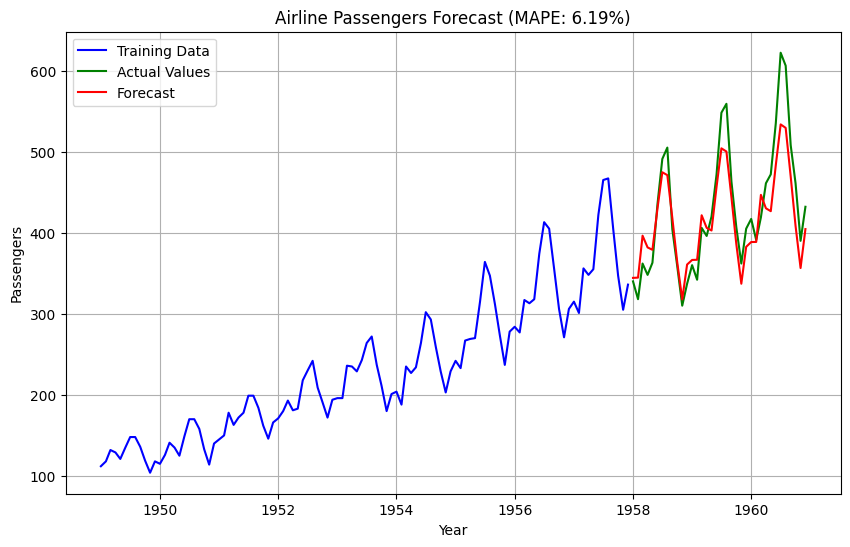

In [7]:
# Ensure the index has a frequency
y.index = pd.PeriodIndex(y.index, freq="M")  # Convert index to PeriodIndex with monthly frequency

# Split data into train and test sets (last 36 months as test)
y_train, y_test = temporal_train_test_split(y, test_size=36)

# Initialize and fit AutoETS forecaster with automatic model selection
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)

# Create forecasting horizon using test set indices
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Generate forecasts
y_pred = forecaster.predict(fh)

# Calculate evaluation metric
mape = mean_absolute_percentage_error(y_test, y_pred)

# **Ensure indices are converted to DatetimeIndex for plotting**
y_train.index = y_train.index.to_timestamp()
y_test.index = y_test.index.to_timestamp()
y_pred.index = y_pred.index.to_timestamp()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Actual Values', color='green')
plt.plot(y_test.index, y_pred, label='Forecast', color='red')
plt.title(f'Airline Passengers Forecast (MAPE: {mape:.2%})')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()